In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C, RationalQuadratic
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import norm

## Data

In [45]:
 Define the input data points as a NumPy array
X = np.array([
    [0.66579958, 0.12396913],
    [0.87779099, 0.7786275 ],
    [0.14269907, 0.34900513],
    [0.84527543, 0.71112027],
    [0.45464714, 0.29045518],
    [0.57771284, 0.77197318],
    [0.43816606, 0.68501826],
    [0.34174959, 0.02869772],
    [0.33864816, 0.21386725],
    [0.70263656, 0.9265642 ],
    [0.736242, 0.833268],
    [0.850452, 0.333325],
    [0.829398, 0.019111],
    [0.156153, 0.778161],
    [0.154506, 0.020868],
    [0.461755, 0.628986],
    [0.494789, 0.568625],
    [0.758352, 0.022117],
    [0.464655, 0.551889],
    [0.519471, 0.548534],
    [0.542443, 0.479991],
    [0.502061, 0.584498]
])


# Define the corresponding target values as a NumPy array
y = np.array([
    0.53899612, 0.42058624, -0.06562362, 0.29399291, 0.21496451, 0.02310555,
    0.24461934, 0.03874902, -0.01385762, 0.61120522, 0.4017329949916669,
    0.4437354807062779, 0.14335039505650726, 0.01020773698805422, 0.12239747912867861,
    0.39839803926180384, 0.8944069888923256, 0.43592906179072105, 0.45149901512862245,
    0.5316127083663216, 0.35291990902104664, 0.6594345910182439
])

## Surrogate model

Removing 0 outliers from evaluation training data
Training initial GPR model for evaluation on scaled training data...
Optimized kernel parameters: 0.878**2 * Matern(length_scale=0.0875, nu=1.5) + WhiteKernel(noise_level=0.0833)
Log marginal likelihood: -22.443373801359044
Test MSE (initial evaluation): 0.056390213305865224
R² Score (initial evaluation): -0.08616252236702238


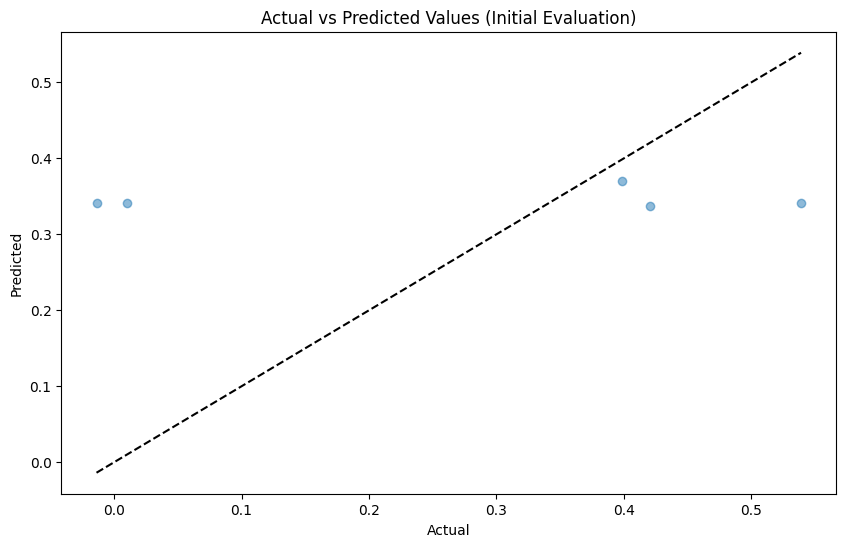

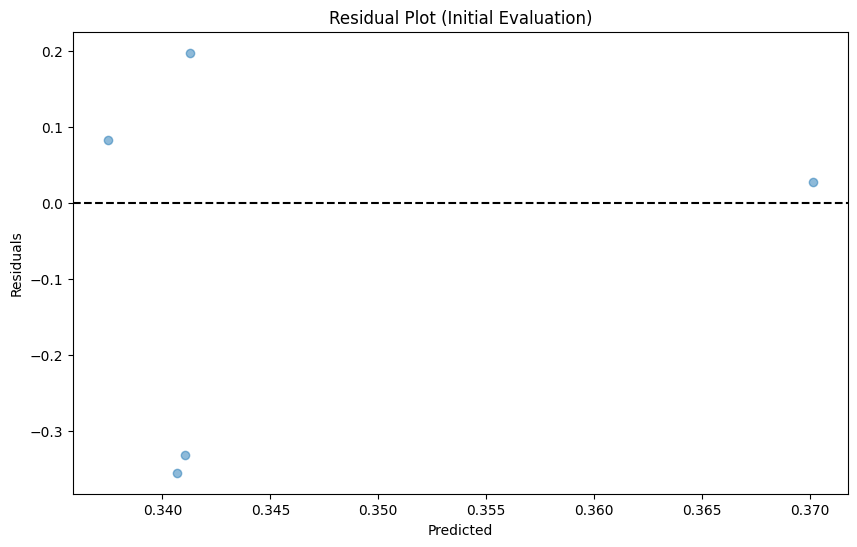

In [46]:
# Define a more robust custom optimizer with increased max_iter and improved parameters
def custom_optimizer(obj_func, initial_theta, bounds):
    # Increase max iterations and add more parameters to improve convergence
    options = {
        'maxiter': 10000,  # Significantly increased max iterations
        'ftol': 1e-10,      # Function tolerance for convergence
        'gtol': 1e-8,      # Gradient tolerance for convergence
        'maxfun': 20000,   # Maximum number of function evaluations
        'maxls': 50        # Maximum number of line search steps
    }
    res = minimize(obj_func, initial_theta, method='L-BFGS-B', jac=True,
                   bounds=bounds, options=options)
    return res.x, res.fun

# --- Initial GPR setup and performance evaluation ---
# Split the initial data into training and testing sets for *initial evaluation* of the GPR performance.
# This split will NOT be used for the BO loop's training, but for showing the model's accuracy on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for and handle outliers in the *evaluation training* target variable
Q1 = np.percentile(y_train, 25)
Q3 = np.percentile(y_train, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_mask = (y_train >= lower_bound) & (y_train <= upper_bound)

print(f"Removing {np.sum(~outlier_mask)} outliers from evaluation training data")
X_train_filtered = X_train[outlier_mask]
y_train_filtered = y_train[outlier_mask]

# --- Ensure data is properly scaled for initial evaluation ---
# Create a robust scaler instance (global variable).
# This 'scaler' instance will be updated throughout the BO process.
global scaler
scaler = RobustScaler()
# Fit scaler only on evaluation training data
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test)  # Transform test data using the fitted scaler

# --- Define a more flexible kernel (global variable) ---
global kernel
kernel = C(1.0) * Matern(length_scale=1.0, length_scale_bounds=(1e-4, 1e3), nu=1.5) + \
                  WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-12, 10.0))

# Initialize the GPR model (global variable) with the custom optimizer.
# This 'gpr_model' instance will be updated throughout the BO process.
global gpr_model
gpr_model = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=50,
    optimizer=custom_optimizer,
    random_state=0,
    normalize_y=True,         # Normalize target values
    alpha=1e-2               # Increased regularization to mitigate ConvergenceWarning
)

print("Training initial GPR model for evaluation on scaled training data...")
# Train the GPR model ONLY on the scaled evaluation training data for initial performance metrics
gpr_model.fit(X_train_scaled, y_train_filtered)

# Make predictions for initial evaluation
y_pred = gpr_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized kernel parameters: {gpr_model.kernel_}")
print(f"Log marginal likelihood: {gpr_model.log_marginal_likelihood(gpr_model.kernel_.theta)}")
print(f"Test MSE (initial evaluation): {mse}")
print(f"R² Score (initial evaluation): {r2}")

# Visualize predictions vs actual (for initial evaluation)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Initial Evaluation)')
plt.show()

# Plot residuals (for initial evaluation)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot (Initial Evaluation)')
plt.show()

# --- IMPORTANT FOR BO ---
# For Bayesian Optimization, we will use the *entire* accumulated X and y data to train the GPR model.
# The `scaler` and `gpr_model` global instances will be re-fitted on the growing dataset in the BO loop.

## Visualization

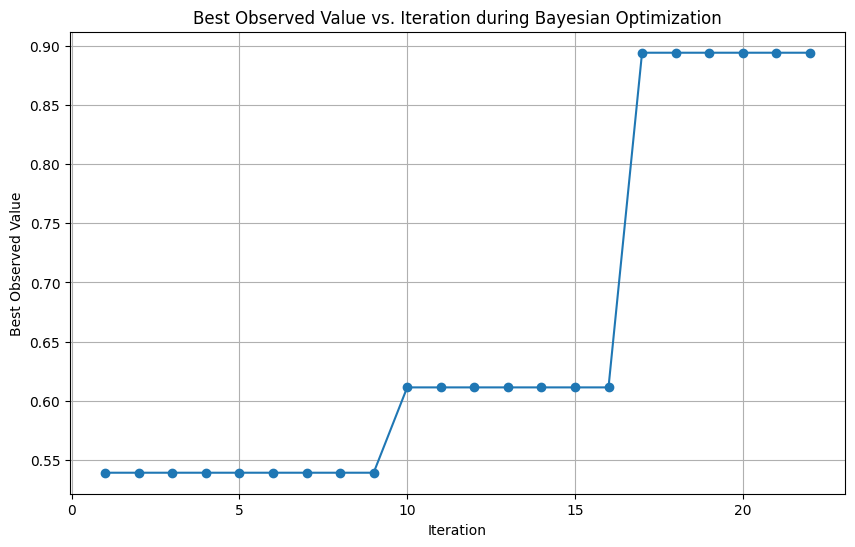

In [48]:
# Assuming 'y' is the array of all observed values during the optimization
# Calculate the best observed value at each iteration
best_y_per_iteration = np.maximum.accumulate(y)

# Plot the best observed value per iteration
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_y_per_iteration) + 1), best_y_per_iteration, marker='o', linestyle='-')
plt.title('Best Observed Value vs. Iteration during Bayesian Optimization')
plt.xlabel('Iteration')
plt.ylabel('Best Observed Value')
plt.grid(True)
plt.show()


## Acquisition function

### Evaluate Candidate Points with UCB/EI/PI


In [ ]:
# Define a custom optimizer with increased max_iter for L-BFGS-B (re-declared for self-containment)
def custom_optimizer(obj_func, initial_theta, bounds):
    options = {
        'maxiter': 10000,
        'ftol': 1e-10,
        'gtol': 1e-8,
        'maxfun': 15000,
        'maxls': 50
    }
    res = minimize(obj_func, initial_theta, method='L-BFGS-B', jac=True,
                   bounds=bounds, options=options)
    return res.x, res.fun

# Define the UCB Acquisition Function
def upper_confidence_bound_gpr(X_new, model, kappa=0.1):
    mean_prediction, std_prediction = model.predict(X_new, return_std=True)
    std_prediction = np.maximum(std_prediction, 1e-9)
    upper_confidence_bound_value = mean_prediction + kappa * std_prediction
    return upper_confidence_bound_value

# Define the EI Acquisition Function
def expected_improvement_gpr(X_new, model, Y_best, xi=0.01):
    mean_prediction, std_prediction = model.predict(X_new, return_std=True)
    std_prediction = np.maximum(std_prediction, 1e-9)
    improvement = mean_prediction - Y_best - xi
    Z = improvement / std_prediction
    ei = improvement * norm.cdf(Z) + std_prediction * norm.pdf(Z)
    return np.maximum(0, ei)

# Define the PI Acquisition Function
def probability_of_improvement_gpr(X_new, model, Y_best, xi=0.01):
    mean_prediction, std_prediction = model.predict(X_new, return_std=True)
    std_prediction = np.maximum(std_prediction, 1e-9)
    improvement = mean_prediction - Y_best - xi
    Z = improvement / std_prediction
    pi = norm.cdf(Z)
    return pi

# --- Setup GPR model for Bayesian Optimization ---
# Ensure the global scaler and gpr_model are used and updated for the start of BO.
# These will be the instances used by the subsequent BO loop.
global scaler, gpr_model, kernel # Ensure access to global instances

scaler = RobustScaler() # Re-instantiate scaler to ensure clean state
X_full_scaled = scaler.fit_transform(X) # Fit scaler on the *entire* current X dataset

kernel = C(1.0) * Matern(length_scale=1.0, length_scale_bounds=(1e-4, 1e3), nu=1.5) + \
                  WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-12, 10.0))

gpr_model = GaussianProcessRegressor( # Re-instantiate gpr_model
    kernel=kernel,
    n_restarts_optimizer=50,
    optimizer=custom_optimizer,
    random_state=0,
    normalize_y=True,
    alpha=1e-2
)

print("Training GPR model on all current data for Bayesian Optimization...")
gpr_model.fit(X_full_scaled, y) # Train on the *entire* current X and y
print("Gaussian Process Regressor model trained.")

# --- Generate Candidate Points for evaluating acquisition functions ---
# Define the bounds of the search space based on the observed data
x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
x2_min, x2_max = X[:, 1].min(), X[:, 1].max()


# --- Generating Random Points ---
n_random_points = 50000

random_candidate_points = np.random.uniform(low=[x1_min, x2_min],
                                            high=[x1_max, x2_max],
                                            size=(n_random_points, 2))

# Scale the random candidate points before passing them to the GPR model
random_candidate_points_scaled = scaler.transform(random_candidate_points)

# --- Evaluate Candidate Points with UCB, EI, and PI ---
kappa_ucb = 0.1
random_ucb_values_gpr = upper_confidence_bound_gpr(random_candidate_points_scaled, gpr_model, kappa=kappa_ucb)
max_ucb_index_random_gpr = np.argmax(random_ucb_values_gpr)
next_query_point_ucb = random_candidate_points[max_ucb_index_random_gpr]


current_best_y = np.max(y) # Get the current best observed value from the *entire* y
xi_pi = 0.01
random_ei_values_gpr = expected_improvement_gpr(random_candidate_points_scaled, gpr_model, current_best_y, xi=xi_pi)
max_ei_index_random_gpr = np.argmax(random_ei_values_gpr)
next_query_point_ei = random_candidate_points[max_ei_index_random_gpr]

xi_pi = 0.01
random_pi_values_gpr = probability_of_improvement_gpr(random_candidate_points_scaled, gpr_model, current_best_y, xi=xi_pi)
max_pi_index_random_gpr = np.argmax(random_pi_values_gpr)
next_query_point_pi = random_candidate_points[max_pi_index_random_gpr]

print("\nRecommended next query points based on each acquisition function:")
print(f"  UCB: {[f'{val:.6f}' for val in next_query_point_ucb]} (UCB value: {random_ucb_values_gpr[max_ucb_index_random_gpr]:.4f})")
print(f"  EI: {[f'{val:.6f}' for val in next_query_point_ei]} (EI value: {random_ei_values_gpr[max_ei_index_random_gpr]:.4f})")
print(f"  PI: {[f'{val:.6f}' for val in next_query_point_pi]} (PI value: {random_pi_values_gpr[max_pi_index_random_gpr]:.4f})")